In [605]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the dataset
DKI1 = pd.read_excel("DATA ISPU - Normalization.xlsx", sheet_name="DKI5")
X = DKI1.index.values.reshape(-1, 1)
y = DKI1['NO2'].values.reshape(-1,)

In [606]:
# Making Train-Test Splits and Data Normalisation
m = 14
per = (0.7 * 2191) / 2191
size = int(len(X) * per)
X_train, X_test = X[0:size], X[size:len(X)]
y_train, y_test = y[0:size], y[size:len(y)]
mean_train = np.mean(y_train)
sd_train = np.std(y_train)
y_train = (y_train - mean_train) / sd_train
y_test = (y_test - mean_train) / sd_train

In [607]:
# Reshape the train and test data into the form that needs to be fed into the ELM
def reshape_data(data, m):
    X_data, y_data = [], []
    for i in range(len(data) - m):
        X_data.append(data[i:i + m])
        y_data.append(data[i + m])
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

X_train, y_train = reshape_data(y_train, m)
X_test, y_test = reshape_data(y_test, m)

In [608]:
# Building the ELM model
input_size = X_train.shape[1]
hidden_size = 500

 # no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1
w_hi = 1
b_lo = -1
b_hi = 1


In [609]:
# Initializing input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,
                                    size=[input_size, hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,
                             size=[hidden_size])



In [610]:
def elu(x):  # hidden layer activation function
    alpha = 1.0  # Parameter determining the negative saturation point
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = elu(G)  # Use ELU activation function instead of ReLU
    return H

# Rest of the code remains the same
output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction_train = predict(X_train)
prediction_test = predict(X_test)


In [611]:
# Evaluating Time Series Forecasting
y_train = (y_train * sd_train) + mean_train
prediction_train = (prediction_train * sd_train) + mean_train

y_test = (y_test * sd_train) + mean_train
prediction_test = (prediction_test * sd_train) + mean_train

# Evaluate forecasts
rmse_train = math.sqrt(mean_squared_error(y_train, prediction_train))
mse_train = mean_squared_error(y_train, prediction_train)
mae_train = mean_absolute_error(y_train, prediction_train)
r2_train = r2_score(y_train, prediction_train)

rmse_test = math.sqrt(mean_squared_error(y_test, prediction_test))
mse_test = mean_squared_error(y_test, prediction_test)
mae_test = mean_absolute_error(y_test, prediction_test)
r2_test = r2_score(y_test, prediction_test)

print('%.3f' % rmse_train)
print('%.3f' % mse_train)
print('%.3f' % mae_train)
print('%.3f' % r2_train)
print('------------------------------')
print('%.3f' % rmse_test)
print('%.3f' % mse_test)
print('%.3f' % mae_test)
print('%.3f' % r2_test)

0.020
0.000
0.013
0.960
------------------------------
0.189
0.036
0.132
-4.741


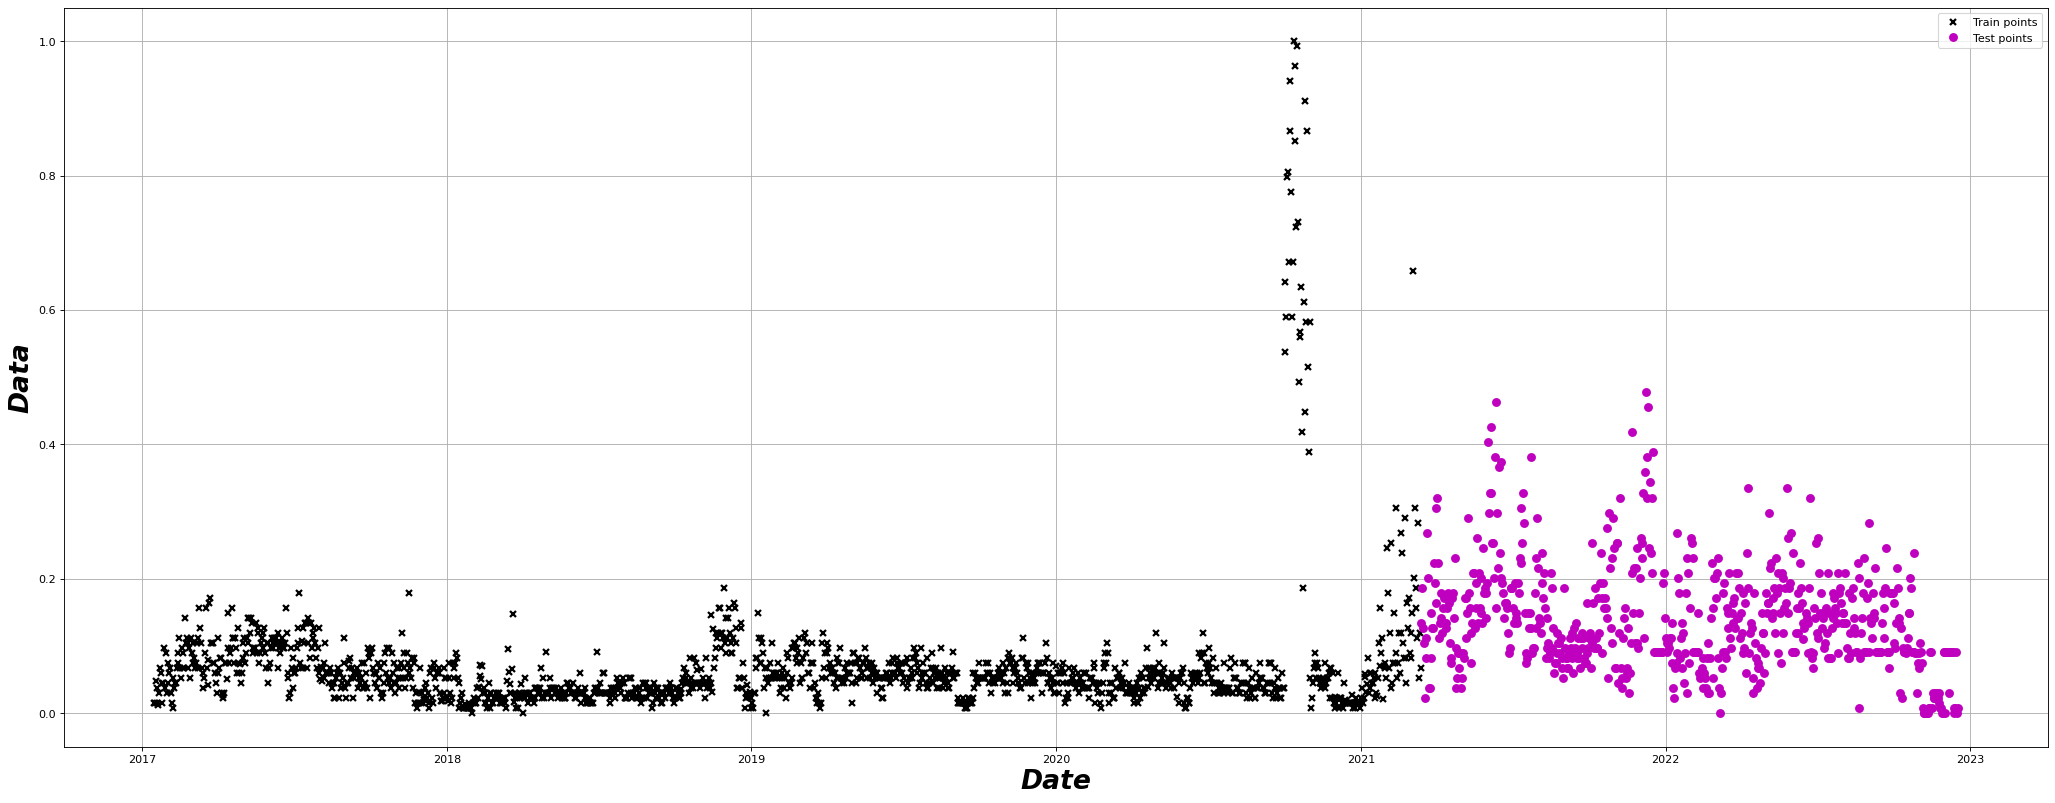

In [612]:
    # Plot observations
plt.figure(figsize=(32, 12), dpi=80)
plt.plot(DKI1['Tanggal'].iloc[m:m+len(X_train)], y_train, "kx", mew=2, label='Train points')
plt.plot(DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)], y_test, "mo", mew=2, label='Test points')

# Annotate plot
plt.xlabel("Date", fontsize=24, style='italic', fontweight='bold')
plt.ylabel("Data", fontsize=24, style='italic', fontweight='bold')
plt.grid()
plt.legend()
plt.show()


## Menampilkan Hasil Prediksi Data Test

In [613]:
# Convert the predicted values to a dataframe
prediction_test_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)],
    'SO2': y_test,
    'Prediksi': prediction_test
})

print("\nTest Set Predictions:")
print(prediction_test_df)


Test Set Predictions:
        Tanggal       SO2  Prediksi
1533 2021-03-14  0.134328  0.075714
1534 2021-03-15  0.186567  0.164713
1535 2021-03-16  0.126866 -0.018130
1536 2021-03-17  0.104478 -0.095315
1537 2021-03-18  0.022388  0.035450
...         ...       ...       ...
2172 2022-12-13  0.000000 -0.043887
2173 2022-12-14  0.007463  0.052141
2174 2022-12-15  0.091133  0.038035
2175 2022-12-16  0.000000  0.128025
2176 2022-12-17  0.007463 -0.031596

[644 rows x 3 columns]


## Menampilkan Hasil Prediksi Data Train

In [614]:
# Convert the predicted values to a dataframe
prediction_train_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m:m+len(X_train)],
    'SO2': y_train,
    'Prediksi': prediction_train
})

print("Train Set Predictions:")
print(prediction_train_df)

Train Set Predictions:
        Tanggal       SO2  Prediksi
14   2017-01-15  0.014925  0.034944
15   2017-01-16  0.014925  0.038341
16   2017-01-17  0.047761  0.025794
17   2017-01-18  0.037313  0.051096
18   2017-01-19  0.014925  0.012225
...         ...       ...       ...
1528 2021-03-09  0.111940  0.109264
1529 2021-03-10  0.283582  0.282271
1530 2021-03-11  0.052239  0.052737
1531 2021-03-12  0.119403  0.118829
1532 2021-03-13  0.067164  0.068610

[1519 rows x 3 columns]


## Menampilkan Grafik Hasil Prediksi Data Train dan Data Test

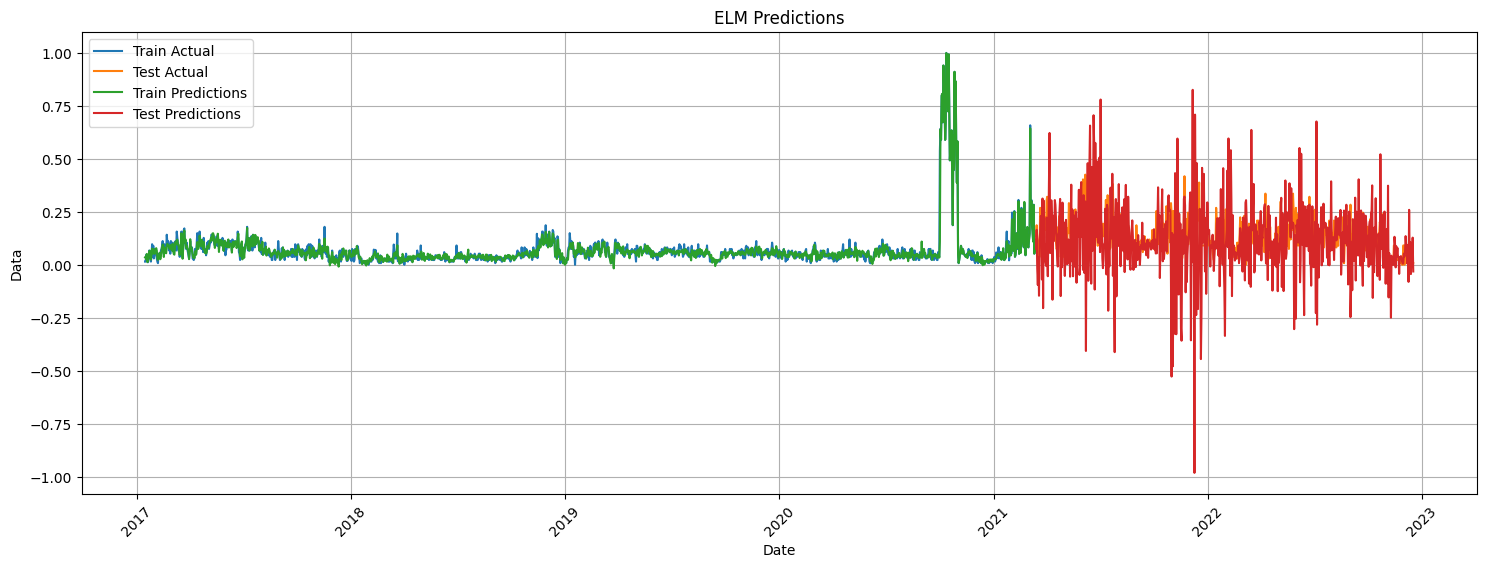

In [615]:
# Plot observations, predictions, train, and test data
plt.figure(figsize=(18, 6))
plt.plot(DKI1['Tanggal'].iloc[m:m+len(X_train)], y_train, label='Train Actual')
plt.plot(DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)], y_test, label='Test Actual')
plt.plot(DKI1['Tanggal'].iloc[m:m+len(X_train)], prediction_train, label='Train Predictions')
plt.plot(DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)], prediction_test, label='Test Predictions')

# Annotate plot
plt.xlabel("Date")
plt.ylabel("Data")
plt.title("ELM Predictions")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Display the plot
plt.show()


## Menampilkan dataframe hasil prediksi data train dan data tes yang sudah digabungkan

In [616]:
# Convert the predicted values to a dataframe
prediction_train_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m:m+len(X_train)],
    'PM10': y_train,
    'Prediksi': prediction_train
})

prediction_test_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)],
    'PM10': y_test,
    'Prediksi': prediction_test
})

# Concatenate the train and test prediction dataframes
prediction_df = pd.concat([prediction_train_df, prediction_test_df], ignore_index=True)

print(prediction_df)


        Tanggal      PM10  Prediksi
0    2017-01-15  0.014925  0.034944
1    2017-01-16  0.014925  0.038341
2    2017-01-17  0.047761  0.025794
3    2017-01-18  0.037313  0.051096
4    2017-01-19  0.014925  0.012225
...         ...       ...       ...
2158 2022-12-13  0.000000 -0.043887
2159 2022-12-14  0.007463  0.052141
2160 2022-12-15  0.091133  0.038035
2161 2022-12-16  0.000000  0.128025
2162 2022-12-17  0.007463 -0.031596

[2163 rows x 3 columns]


## Menormalisasi Hasil prediksi dengan scala 0 - 100

In [617]:
# Normalize train and test data
max_value = 100.0
min_value = 0.0
y_train_denorm = y_train * (max_value - min_value) + min_value
prediction_train_denorm = prediction_train * (max_value - min_value) + min_value

y_test_denorm = y_test * (max_value - min_value) + min_value
prediction_test_denorm = prediction_test * (max_value - min_value) + min_value

# Convert the denormalized predicted values to a dataframe
prediction_train_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m:m+len(X_train)],
    'PM10': y_train_denorm,
    'Prediksi': prediction_train_denorm
})

prediction_test_df = pd.DataFrame({
    'Tanggal': DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)],
    'PM10': y_test_denorm,
    'Prediksi': prediction_test_denorm
})

# Concatenate the train and test prediction dataframes
prediction_df = pd.concat([prediction_train_df, prediction_test_df], ignore_index=True)

print(prediction_df)


        Tanggal      PM10   Prediksi
0    2017-01-15  1.492537   3.494444
1    2017-01-16  1.492537   3.834117
2    2017-01-17  4.776119   2.579434
3    2017-01-18  3.731343   5.109597
4    2017-01-19  1.492537   1.222487
...         ...       ...        ...
2158 2022-12-13  0.000000  -4.388713
2159 2022-12-14  0.746269   5.214132
2160 2022-12-15  9.113347   3.803539
2161 2022-12-16  0.000000  12.802485
2162 2022-12-17  0.746269  -3.159571

[2163 rows x 3 columns]


## Menampilkan Grafik dengan data yang sudah dinormalisasi

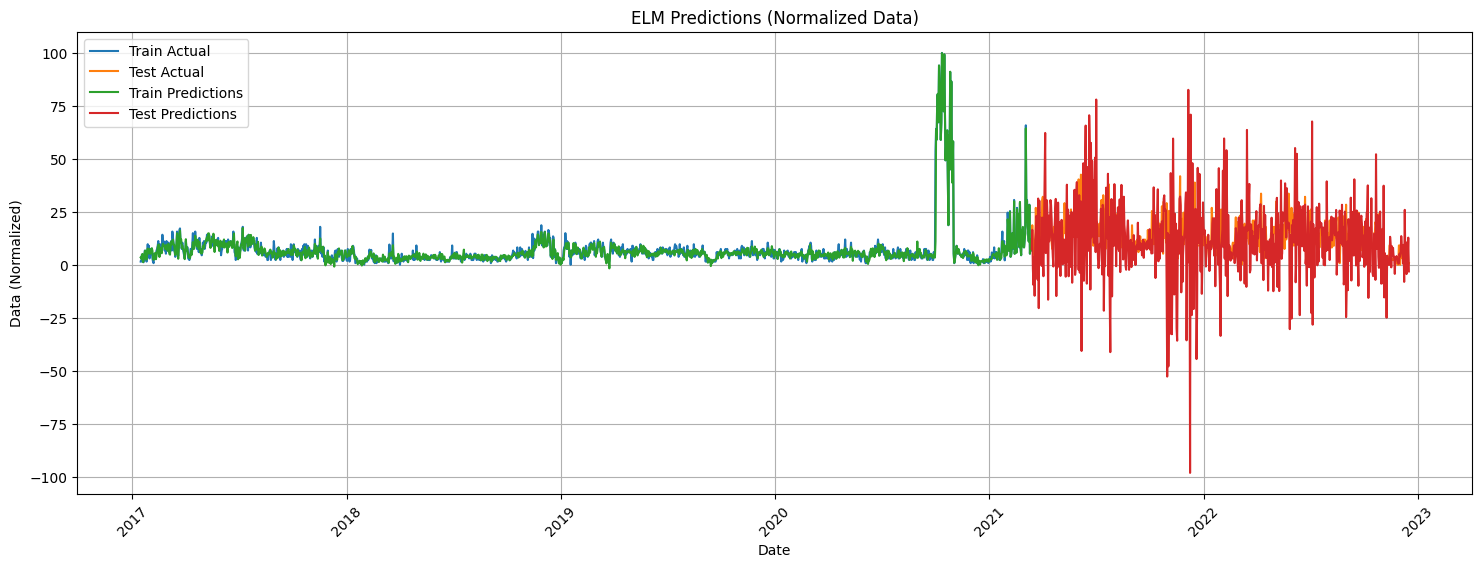

In [618]:
# Plot observations, predictions, train, and test data
plt.figure(figsize=(18, 6))
plt.plot(DKI1['Tanggal'].iloc[m:m+len(X_train)], y_train_denorm, label='Train Actual')
plt.plot(DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)], y_test_denorm, label='Test Actual')
plt.plot(DKI1['Tanggal'].iloc[m:m+len(X_train)], prediction_train_denorm, label='Train Predictions')
plt.plot(DKI1['Tanggal'].iloc[m+len(X_train):m+len(X_train)+len(X_test)], prediction_test_denorm, label='Test Predictions')

# Annotate plot
plt.xlabel("Date")
plt.ylabel("Data (Normalized)")
plt.title("ELM Predictions (Normalized Data)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [619]:
# Menyimpan DataFrame ke dalam file Excel
#prediction_df.to_excel('E:/TA/HASIL ELM/DKI5_NO2_pred.xlsx', index=False)